In [53]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np


In [54]:
T = 1000  # Total number of points
time = np.arange(1, T + 1, dtype=np.float32)
x = np.sin(0.01 * time) + np.random.normal(0, 0.2, (T,))


(1.0, 1000.0)

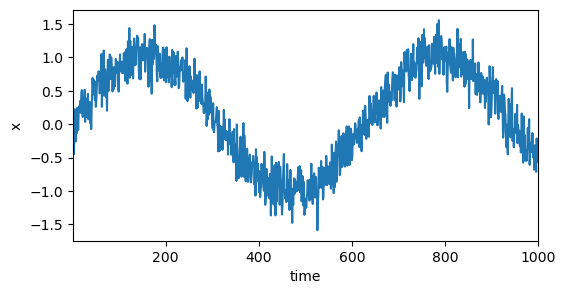

In [55]:
from matplotlib import pyplot as plt

plt.figure(figsize=(6, 3))
plt.plot(time, x)
plt.ylabel('x')
plt.xlabel('time')
plt.xlim([1, 1000])

In [56]:
tau = 4   # Number of time steps used for input

# Assuming 'x' is already defined as the data sequence
features = np.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]

# Convert features to a PyTorch tensor
features_tensor = torch.tensor(features, dtype=torch.float32)

# Convert labels to a PyTorch tensor
labels_tensor = torch.tensor(x[tau:].reshape((-1, 1)), dtype=torch.float32)


In [57]:
# Split the data into training and labels (you can modify this if needed)
# In this case, we treat the `x` as the target value for regression
n_train = 996  # Number of training samples
features = time[:n_train]  # Use 'time' as features for simplicity
labels = x[:n_train]  # The noisy sine wave as the labels

# Convert data to PyTorch tensors
features_tensor = torch.tensor(features, dtype=torch.float32).view(-1, 1)  # Reshape for single feature
labels_tensor = torch.tensor(labels, dtype=torch.float32).view(-1, 1)  # Reshape for single label

# Create a PyTorch Dataset
dataset = TensorDataset(features_tensor, labels_tensor)

# Create a DataLoader
batch_size = 16
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [58]:
# A simple MLP
# Define the neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Adjust the input size for the first layer
        self.fc1 = nn.Linear(1, 64)  # 1 input feature -> 64 output features
        self.fc2 = nn.Linear(64, 1)  # 64 input features -> 1 output feature

    def forward(self, x):
        x = F.relu(self.fc1(x))  # Apply ReLU activation after first layer
        x = self.fc2(x)  # Output layer
        return x

# Create the model
net = Net()

In [59]:
history = []

def train(net, train_loader, loss_fn, epochs, lr):
    # Define the optimizer
    optimizer = optim.Adam(net.parameters(), lr=lr)

    # Set the model to training mode
    net.train()

    for epoch in range(epochs):
        running_loss = 0.0
        
        # Iterate through the training data loader
        for X, y in train_loader:
            # Move the data to the device (e.g., CPU or GPU)
            X, y = X.float(), y.float()  # Ensure correct types for float-based calculations

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = net(X)

            # Compute loss
            loss = loss_fn(outputs, y)
            running_loss += loss.item()

            # Backward pass (compute gradients)
            loss.backward()

            # Update model parameters
            optimizer.step()

        # Log the loss for the epoch
        history.append(running_loss / len(train_loader))
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}")
# Assuming train_loader is a PyTorch DataLoader
train_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)  # Replace 'dataset' with your actual dataset
loss_fn = nn.MSELoss()  # Assuming this is a regression task
train(net, train_loader, loss_fn, epochs=5, lr=0.01)

Epoch 1/5, Loss: 1992.8131
Epoch 2/5, Loss: 52.4193
Epoch 3/5, Loss: 2.0038
Epoch 4/5, Loss: 0.7721
Epoch 5/5, Loss: 0.5226


Text(0.5, 0, 'Iteration')

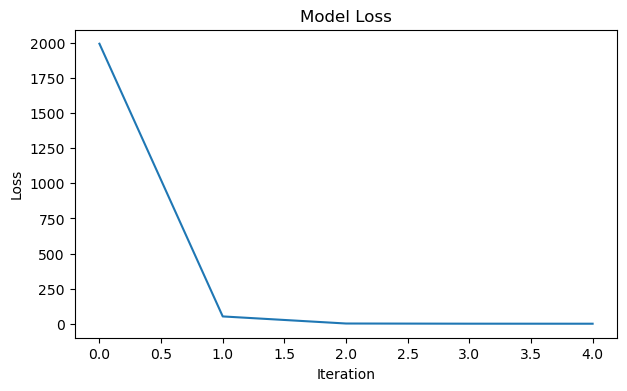

In [60]:
plt.figure(figsize=(7, 4))
plt.plot(history)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Iteration')

In [61]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib.

    Defined in :numref:`sec_calculus`"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()


def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(6, 3), axes=None):
    """Plot data points.

    Defined in :numref:`sec_calculus`"""
    if legend is None:
        legend = []

    #plt.figure(figsize)
    axes = axes if axes else plt.gca()

    # Return True if `X` (tensor or list) has 1 axis
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)

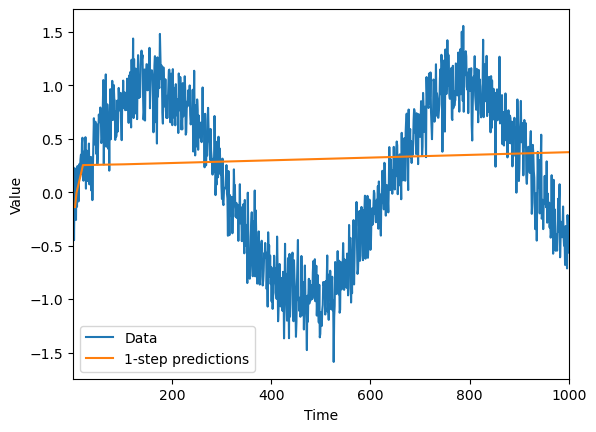

<Figure size 600x300 with 0 Axes>

In [62]:
onestep_preds = net(features_tensor)

plot([time, time[tau:]], [x.asnumpy(), onestep_preds.asnumpy()], 'time',
      'x', legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))